# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

In [78]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, explode,array,lit,coalesce,countDistinct
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

In [79]:
# create a Spark session
spark = SparkSession \
        .builder\
        .appName('Sparkify')\
        .getOrCreate()

# Load and Exploratory Data
The mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data

In [80]:
class load_clean:
    
    """
    Build a class to be load and show the characters of dataset and remove the records without "userId"
    
    """
    

    def __init__(self, dataset):
        
        """
        INPUT: (json) dataset file
    
        OUTPUT: print the characters of dataset:The amount of record, the Schema, the summary of missing value
        """
        #read dataset from file
        self.data = dataset
        self.user_log = spark.read.json(self.data)
        
        #print the characters of dataset
        print('the data has been load...')
        print('----------------------------------------------------------------------------------------------------------------------')
        
        print('The amount of record in origin dataset:', self.user_log.count(),'.The amount of fields in origin dataset:',len(self.user_log.columns))
        print('----------------------------------------------------------------------------------------------------------------------')
        
        print('the first record is', self.user_log.head())
        print('----------------------------------------------------------------------------------------------------------------------')
        
        print('the Schema:')
        print(self.user_log.printSchema())
        print('----------------------------------------------------------------------------------------------------------------------')
        
        print('the summary of missing value')
        print(self.user_log.select([count(when(col(colu).isNull() | isnan(colu) , colu))\
         .alias(colu) for colu in self.user_log.columns])\
         .collect())
        print('----------------------------------------------------------------------------------------------------------------------')
        
    def clean(self):
        
        # remove rows with empty userId
        self.user_log_cleaned = self.user_log.filter(self.user_log["userId"] != "")
        print('The cleaned data has been created')
        print('----------------------------------------------------------------------------------------------------------------------')
        
        #show the amount of records in new user_log
        print('The amount of records in The cleaned data:' , self.user_log_cleaned.count())
        print('----------------------------------------------------------------------------------------------------------------------')
        
        return  self.user_log_cleaned

In [81]:
dataset = 'mini_sparkify_event_data.json'

#Get data
data = load_clean(dataset).clean()

the data has been load...
----------------------------------------------------------------------------------------------------------------------
The amount of record in origin dataset: 286500 .The amount of fields in origin dataset: 18
----------------------------------------------------------------------------------------------------------------------
the first record is Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')
----------------------------------------------------------------------------------------------------------------------
the Schema:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: str

In [82]:
def columnsGroupbyType(input_dataframe):
                       
    """
    INPUT: dataset
    OUTPUT: A series include the groups of columns 
    """
    type_df = pd.DataFrame(input_dataframe.dtypes)
    type_df.columns = ['column', 'type']
    result = (type_df.groupby('type')['column'].apply(list), type_df.groupby('type')['column'].apply(list).index[:])
    
    print('There are {} typies values in dataset.'.format(len(result[1])))
    print('Show below...')
    for i in range(len(result[1])):
        print('typy: ',result[1][i])
        print(result[0][i])
        
    return result

In [83]:
def data_describe(info, dataset):
    
    """
    INPUT: dataset, information of columns
    OUTPUT: the static analysis of columns
    """
    for i in range(len(info[1])):
        if len(info[0][i])<=8:
            dataset.select(info[0][i]) \
                 .describe() \
                 .show()
        else:
            start  = 0
            end = 8
            while end < len(info[0][i]):
                dataset.select(info[0][i][start : end]) \
                 .describe() \
                 .show()    
                start = end
                end = end + 8
            if start <  len(info[0][i]):
                 dataset.select(info[0][i][start:]) \
                 .describe() \
                 .show()  
                          
    return

In [84]:
info_columns = columnsGroupbyType(data)
data_describe(info_columns,data)

There are 3 typies values in dataset.
Show below...
typy:  bigint
['itemInSession', 'registration', 'sessionId', 'status', 'ts']
typy:  double
['length']
typy:  string
['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
+-------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|        registration|         sessionId|            status|                  ts|
+-------+------------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|       1521380675000|     

In [85]:
#show the numders of user
number_users = data.select(countDistinct("userId"))
number_users.show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [86]:
def dsitribution_column(col, dataset):
    """
    
    INPUT: dataset, specfic columns
    OUTPUT: the distribution of specific columns in dataset
    """
    
    for c in col:

        col_stat = dataset.groupBy(c).count().orderBy(c)
        col_stat.show()
        ax = sns.barplot(x=c,y='count',data=col_stat.toPandas(),color='blue')
        plt.savefig('{}.jpg'.format(c))


+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+

+------+------+
|method| count|
+------+------+
|   GET| 20336|
|   PUT|257818|
+------+------+

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



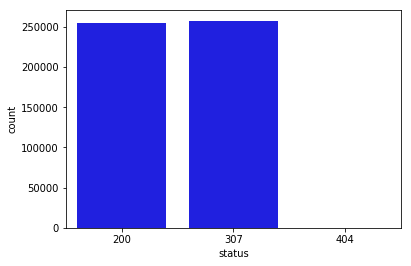

In [87]:
columns = ["gender","level","method","status"]
dsitribution_column(columns, data)

# Create churn label

In [88]:
#page values
page_stat= data.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")
page_stat.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     10082|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       495|
|            Settings|      1514|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1454|
|             Upgrade|       499|
|               Error|       252|
|      Submit Upgrade|       159|
+--------------------+----------+



In [89]:
cancel_Cancellation_account = data.filter(col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID'])
cancel_Cancellation_account.show(5,False)

+------+
|userID|
+------+
|18    |
|18    |
|32    |
|32    |
|125   |
+------+
only showing top 5 rows



The number of cancel is same with the number of cancellation conformation. users get cancel conformation after did cancel action. This result show that the 'cancel' and 'Cancellation Confirmation' are duplicate records. Then I would only select 'Cancellation Confirmation' as churn = 1

In [90]:
# define churn
define_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# add feature label 
data_new = data.withColumn("label", define_churn("page"))
# print top 5
data_new.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', label=0)

# Data engineering


In [91]:


def creat_features(data):
    
    """
    create new features
    INPUT: dataset
    OUTPUT: dataset with new features
    """
    
    columns = ["userId","song", "gender", "level", "page", "label"]
    data = data_new.select(columns)
    # define gender_new
    define_gender_new = udf(lambda x: 1 if x == "M" else 0, IntegerType())
    # add feature GenderNew
    data = data.withColumn("GenderNew", define_gender_new("gender"))


    # define level_new
    define_level_new = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
    # add feature LevelNew
    data = data.withColumn("LevelNew", define_level_new("level"))

    # define downgrade
    define_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
    # add feature downgrade
    data = data.withColumn("Downgrade", define_downgrade("page"))

    # define thumbs_up
    define_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
    # add thumbs variables
    data = data.withColumn("ThumbsUp", define_thumbs_up("page"))

    # define thumbs_down
    define_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
    # add thumbs variables
    data= data.withColumn("ThumbsDown", define_thumbs_down("page"))

    # define NextSong
    define_NextSong = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
    # add songs variable
    data = data.withColumn("NextSong", define_NextSong("page"))
    
    return data

In [92]:
data_new = creat_features(data_new)
#show the new features
data_new.select(["userId","GenderNew","LevelNew","ThumbsUp", "ThumbsDown","Downgrade","NextSong"]).show(5)

+------+---------+--------+--------+----------+---------+--------+
|userId|GenderNew|LevelNew|ThumbsUp|ThumbsDown|Downgrade|NextSong|
+------+---------+--------+--------+----------+---------+--------+
|    30|        1|       1|       0|         0|        0|       1|
|     9|        1|       0|       0|         0|        0|       1|
|    30|        1|       1|       0|         0|        0|       1|
|     9|        1|       0|       0|         0|        0|       1|
|    30|        1|       1|       0|         0|        0|       1|
+------+---------+--------+--------+----------+---------+--------+
only showing top 5 rows



In [93]:
def new_features(data):
    
    """
    data engineering for some columns, example: the sum of nextsong
    INPUT: dataset
    OUTPUT: 
    """
    
    data_new_features = data.groupby(data_new.userId).agg({"Downgrade": "max", 
                                                  "GenderNew": "max",
                                                  "LevelNew": "max",
                                                  "NextSong": "sum",
                                                  "ThumbsUp": "sum",
                                                  "ThumbsDown": "sum",
                                                  "label": "max"}) 
    data_new_features = data_new_features.select(col("userId"),
                                       col("max(Downgrade)").alias("Downgrade"),
                                       col("max(GenderNew)").alias("GenderNew"),
                                       col("max(LevelNew)").alias("LevelNew"),
                                       col("sum(NextSong)").alias("sum_NextSong"),
                                       col("sum(ThumbsUp)").alias("sum_thumbsUp"),
                                       col("sum(ThumbsDown)").alias("sum_ThumbsDown"),
                                       col("max(label)").alias("label"))
    return data_new_features

# present result
data_new_features = new_features(data_new)
data_new_features.show(5)

+------+---------+---------+--------+------------+------------+--------------+-----+
|userId|Downgrade|GenderNew|LevelNew|sum_NextSong|sum_thumbsUp|sum_ThumbsDown|label|
+------+---------+---------+--------+------------+------------+--------------+-----+
|100010|        0|        0|       0|         275|          17|             5|    0|
|200002|        0|        1|       1|         387|          21|             6|    0|
|   125|        0|        1|       0|           8|           0|             0|    1|
|    51|        0|        1|       1|        2111|         100|            21|    1|
|   124|        0|        0|       1|        4079|         171|            41|    0|
+------+---------+---------+--------+------------+------------+--------------+-----+
only showing top 5 rows



In [94]:
def oversampling(data):
    a= data.filter(col("label") == False).count()
    b = data.filter(col("label") == True).count()
    if a > b:
        major_user_log = data.filter(col("label") == False)
        minor_user_log = data.filter(col("label") == True)
    else:
        major_user_log = data.filter(col("label") == True)
        minor_user_log = data.filter(col("label") == False)
        
    ratio = int(major_user_log.count()/minor_user_log.count())
    print("the amount of majority : {}.   the amount of minority : {} ".format(major_user_log.count(),minor_user_log.count()))
    print("the ratio is {}".format(ratio))

    # duplicate the minority rows
    oversampled_user_log = minor_user_log.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')
    # combine both oversampled minority rows and previous majority rows 
    combined_data = major_user_log.unionAll(oversampled_user_log)
    print("The amount of records is {} after oversampling".format(combined_data.count()))

    return combined_data

In [95]:
combined_df = oversampling(data_new_features)

the amount of majority : 173.   the amount of minority : 52 
the ratio is 3
The amount of records is 329 after oversampling


About unbalence problem

class (label) 1 has 52 recoeds, while class 0 has only 173 recoeds. We can undersample class 0, or oversample class 1.
These changes are called sampling the dataset 
Here I choosed the oversampling, It is to duplicate the samples from under-represented class, to inflate the numbers till it reaches the same level as the dominant class.

In [96]:
def transfer_feature(data):
    #transfer the features to vector
    assembler = VectorAssembler(inputCols=["Downgrade", "LevelNew", "sum_NextSong", "sum_thumbsUp","sum_ThumbsDown"], outputCol="features")
    combined_data = assembler.transform(data)
    combined_data.select('label', 'features').show(4)
    return combined_data

In [97]:
combined_df = transfer_feature(combined_df)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.0,275.0,17...|
|    0|[0.0,1.0,387.0,21...|
|    0|[0.0,1.0,4079.0,1...|
|    0|[0.0,0.0,150.0,7....|
+-----+--------------------+
only showing top 4 rows



# Modeling

In [104]:
#split data in train dataset, validation dataset and test dataset.
(trainData, tempData)= combined_df.randomSplit(weights = [0.70,0.30])
(valiData, testData)= tempData.randomSplit(weights = [0.50,0.50])

In [105]:
def evaluation(prediction, data_name):
    
    """
    INPUT: prediction model, data_name 
    OUTPUT: the F1 score, accuracy, error of model
    """
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(prediction)
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
    f1_score = f1_score_evaluator.evaluate(prediction)
    print("-----------------------------------------------------------------------------------------------------------------------")
    print("Evaluation on ", data_name)
    print("Accuracy = %g" % accuracy)
    print("Validation Error = %g" % (1.0 - accuracy))
    print("F1 score = %g" % (f1_score))
    print("-----------------------------------------------------------------------------------------------------------------------")
    
    return

 # Tuning 

In [107]:
rf = RandomForestClassifier()
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, label_new])
param_grid = ParamGridBuilder().\
            addGrid(rf.maxDepth, [4,5,6]).\
            addGrid(rf.numTrees, [5,7]).\
            build()
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)
cv_model = cv.fit(trainData)
best_model = cv_model.bestModel

In [108]:
print(cv_model.bestModel.stages)   

[StringIndexer_999be3dcf697, VectorIndexer_249c585e42a0, RandomForestClassificationModel (uid=RandomForestClassifier_9abc2d682489) with 5 trees, IndexToString_00f2cef00853]


In [109]:
print('model:',rf)

#run function evaluation on validation dataset
predictions = best_model.transform(valiData)
evaluation(predictions, 'validation data')

#run function evaluation on test dataset
predictions = best_model.transform(testData)
evaluation(predictions,'test data')

model: RandomForestClassifier_9abc2d682489
-----------------------------------------------------------------------------------------------------------------------
Evaluation on  validation data
Accuracy = 0.77551
Validation Error = 0.22449
F1 score = 0.774381
-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------
Evaluation on  test data
Accuracy = 0.733333
Validation Error = 0.266667
F1 score = 0.733333
-----------------------------------------------------------------------------------------------------------------------


 # Inprovement

In [110]:
dataset = 'mini_sparkify_event_data.json'
#Get data
data = load_clean(dataset).clean()
# define churn
define_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" or x ==  "Downgrade" else 0, IntegerType())
# add feature label 
data_new = data.withColumn("label", define_churn("page"))
# print top 5
data_new.head()

the data has been load...
----------------------------------------------------------------------------------------------------------------------
The amount of record in origin dataset: 286500 .The amount of fields in origin dataset: 18
----------------------------------------------------------------------------------------------------------------------
the first record is Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')
----------------------------------------------------------------------------------------------------------------------
the Schema:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: str

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', label=0)

In [111]:
data_new = creat_features(data_new)
#show the new features
data_new.select(["userId","GenderNew","LevelNew","ThumbsUp", "ThumbsDown","Downgrade","NextSong"]).show(5)
data_new_features = new_features(data_new)
data_new_features.show(5)
combined_df = oversampling(data_new_features)
combined_df = transfer_feature(combined_df)

+------+---------+--------+--------+----------+---------+--------+
|userId|GenderNew|LevelNew|ThumbsUp|ThumbsDown|Downgrade|NextSong|
+------+---------+--------+--------+----------+---------+--------+
|    30|        1|       1|       0|         0|        0|       1|
|     9|        1|       0|       0|         0|        0|       1|
|    30|        1|       1|       0|         0|        0|       1|
|     9|        1|       0|       0|         0|        0|       1|
|    30|        1|       1|       0|         0|        0|       1|
+------+---------+--------+--------+----------+---------+--------+
only showing top 5 rows

+------+---------+---------+--------+------------+------------+--------------+-----+
|userId|Downgrade|GenderNew|LevelNew|sum_NextSong|sum_thumbsUp|sum_ThumbsDown|label|
+------+---------+---------+--------+------------+------------+--------------+-----+
|100010|        0|        0|       0|         275|          17|             5|    0|
|200002|        0|        1|    

In [113]:
#split data in train dataset, validation dataset and test dataset.
(trainData, tempData)= combined_df.randomSplit(weights = [0.70,0.30])
(valiData, testData)= tempData.randomSplit(weights = [0.50,0.50])

In [114]:

rf = RandomForestClassifier()
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, label_new])
param_grid = ParamGridBuilder().\
            addGrid(rf.maxDepth, [4,5,6]).\
            addGrid(rf.numTrees, [5,7]).\
            build()
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)
cv_model = cv.fit(trainData)
best_model = cv_model.bestModel

In [115]:
print('model:',rf)

#run function evaluation on validation dataset
predictions = best_model.transform(valiData)
evaluation(predictions, 'validation data')

#run function evaluation on test dataset
predictions = best_model.transform(testData)
evaluation(predictions,'test data')

model: RandomForestClassifier_c1c51f2ff3f0
-----------------------------------------------------------------------------------------------------------------------
Evaluation on  validation data
Accuracy = 0.894737
Validation Error = 0.105263
F1 score = 0.894737
-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------
Evaluation on  test data
Accuracy = 0.897959
Validation Error = 0.102041
F1 score = 0.897183
-----------------------------------------------------------------------------------------------------------------------


 # Conclusion
In this project, I worked with the Sparkify dataset and predict whether the user churns or not. 
I load and clean data at first, Then exploring the data and data engineering. In the modeling session, Training the three models based on three different machine learning algorithms. 
The final RandomForestClassifier gives me a good evaluation result.